# 1. 라이브러리 Import

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import math

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  # matlab 차트의 기본 크기를 지정

# 2. 함수
1. 일정 시간내 구간 통계치(Rolling Statistics)를 시각화 함수
2. adfuller활용한 ```augmented_dicket_fuller_test``` 함수
3. socre를 출력하는 함수

In [100]:
def plot_rolling_statistics(timeseiries, window=12) :
    
    rolmean = timeseiries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseiries.rolling(window=window).std()    # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해본다.
    orig = plt.plot(timeseiries, color="blue", label="Original")
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    

In [101]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력한다.
    print('Result of Dickey-Fuller Test:')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Ciritical value (%s)' % key] = value
    print(dfoutput)

In [102]:
def print_score(y_label, y_pred) :

    mse = mean_squared_error(np.exp(y_label), np.exp(y_pred))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(y_label), np.exp(y_pred))
    print('MAE: ', mae)

    rmse = math.sqrt(mse)
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(y_pred) - np.exp(y_label))/np.abs(np.exp(y_label)))
    print('MAPE: {:.2f}%'.format(mape*100))


# 3. 코드
- 3개 기업의 주식 데이터 분석
    1. sk
    2. google
    3. AT&T

## 3-1) sk의 주식 데이터 분석

### 데이터 준비
1. ```read_csv```로 csv파일 읽기
2. Time Series 추출
3. log함수 변환
    - 시간 추이에 따라 분산이 점점 커지고 있을 때
3. 시계열 데이터의 안정성 확인
    - 정성적 그래프 분석
    - 정량적 Augmented Dicky-Fuller Test
    - 시계열 분해 (Time Series Decomposition)


#### csv파일 읽기

In [103]:
# Time Series 생성
df = pd.read_csv('../stock_prediction/data/sk.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,390100.0,405000.0,347000.0,380000.0,209956.234375,359000.0
1,2000-01-05,323000.0,365000.0,323000.0,323000.0,178462.781250,572000.0
2,2000-01-06,350000.0,352000.0,322500.0,328700.0,181612.140625,418000.0
3,2000-01-07,308000.0,350000.0,307000.0,336000.0,185645.484375,342000.0
4,2000-01-10,360000.0,383000.0,355000.0,370000.0,204431.078125,270000.0
...,...,...,...,...,...,...,...
5182,2020-08-07,223500.0,230000.0,219000.0,229000.0,229000.000000,858608.0
5183,2020-08-10,231500.0,240000.0,230500.0,238000.0,238000.000000,812761.0
5184,2020-08-11,240000.0,241000.0,232500.0,237000.0,237000.000000,530433.0
5185,2020-08-12,235500.0,242000.0,232500.0,241500.0,241500.000000,565000.0


#### time series 추출

In [13]:
# time series 추출
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2000-01-04    380000.0
2000-01-05    323000.0
2000-01-06    328700.0
2000-01-07    336000.0
2000-01-10    370000.0
Name: Close, dtype: float64

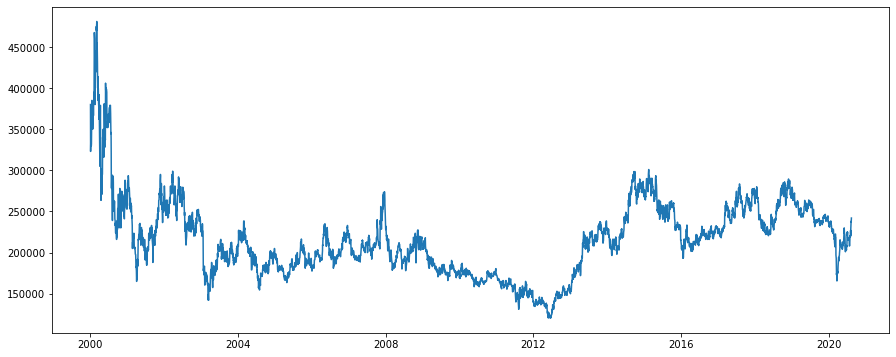

In [14]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()

#### log함수 변환

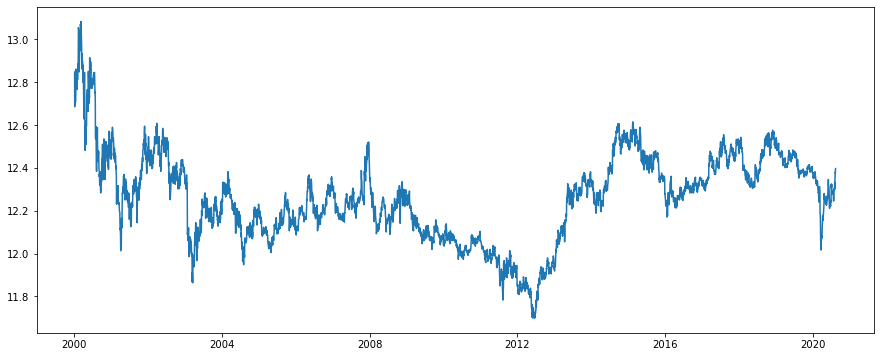

In [15]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

#### 시계열 데이터 안정성확인

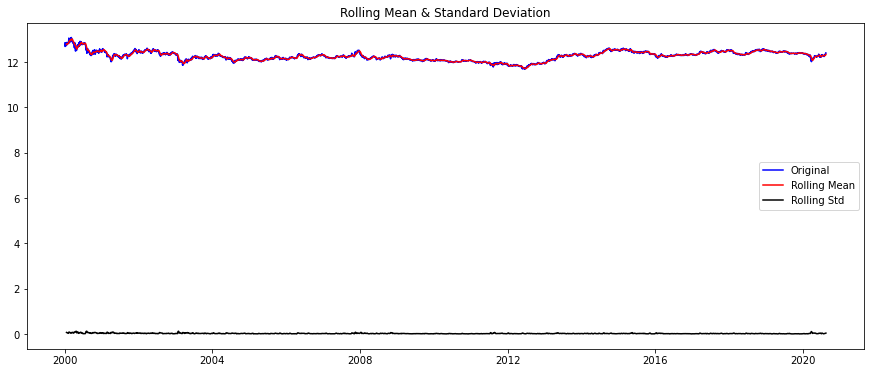

Result of Dickey-Fuller Test:
Test Statistic                   -3.420856
p-value                           0.010268
#Lags Used                       15.000000
Number of Observations Used    5171.000000
Ciritical value (1%)             -3.431615
Ciritical value (5%)             -2.862099
Ciritical value (10%)            -2.567068
dtype: float64


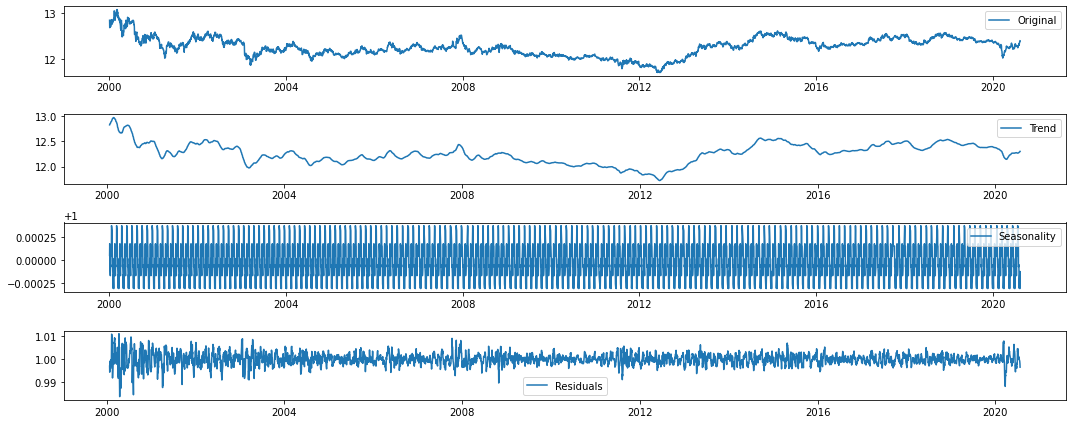

In [16]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

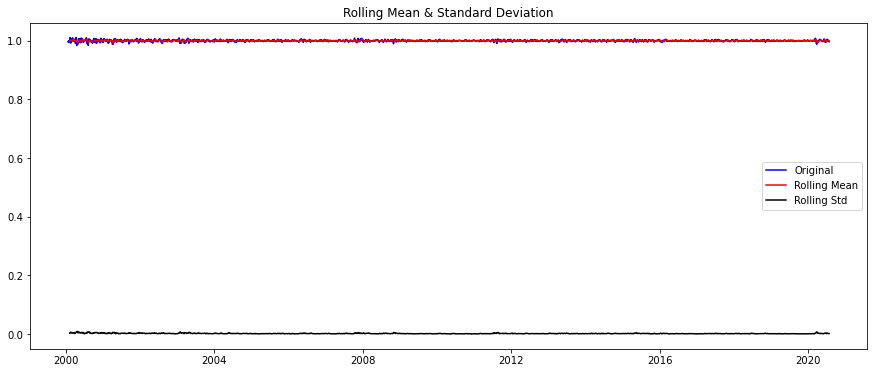

Result of Dickey-Fuller Test:
Test Statistic                -1.707543e+01
p-value                        7.772722e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Ciritical value (1%)          -3.431627e+00
Ciritical value (5%)          -2.862104e+00
Ciritical value (10%)         -2.567070e+00
dtype: float64


In [17]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### 데이터 나누기
- 가장 최근에 급등하는 데이터부분을 제거 
    - ```MAPE``` : 10.49 -> 9.49%

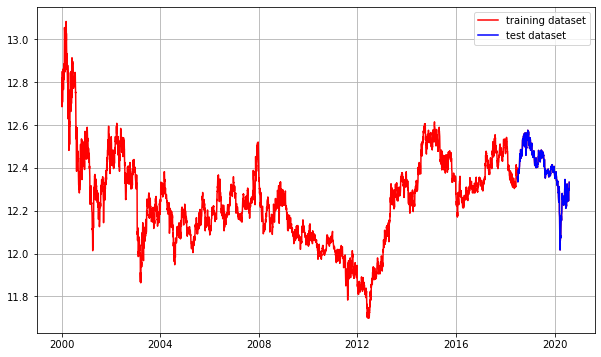

In [18]:
ts_log = ts_log[:int(len(ts_log)*0.999)]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 모수선택
- 다음의 조건인 값을 사용한다 : ```p+q<2```, ```p*q=0```
- ACF : p를 구한다.
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF : q를 구한다.
    - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
- 차분 안정성을 확인하면서 d를 구한다.

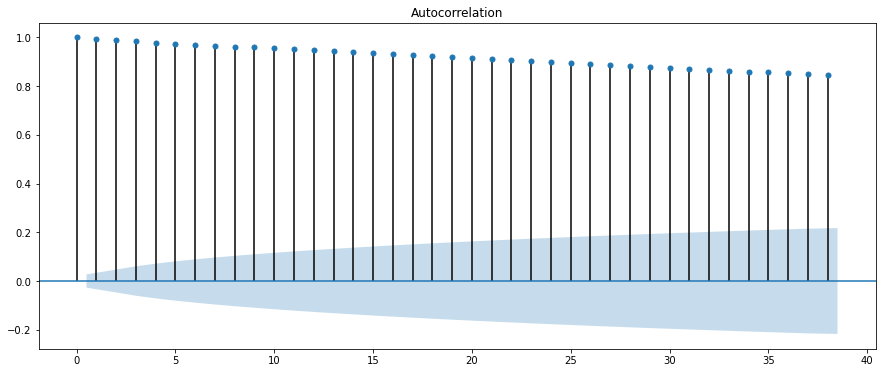

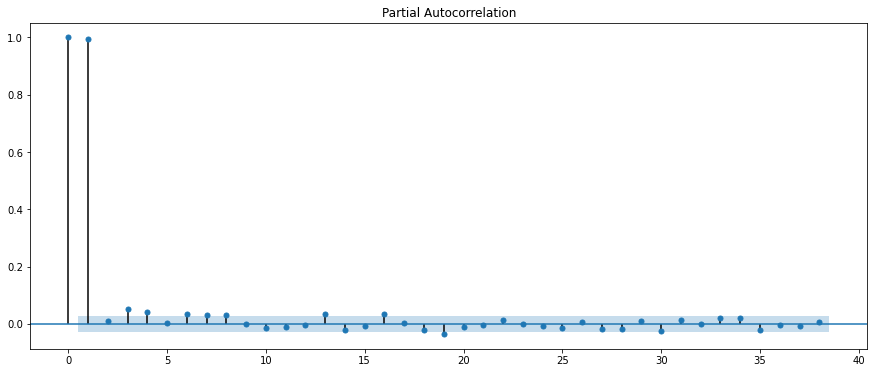

In [19]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                  -20.481303
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5165.000000
Ciritical value (1%)             -3.431617
Ciritical value (5%)             -2.862100
Ciritical value (10%)            -2.567068
dtype: float64


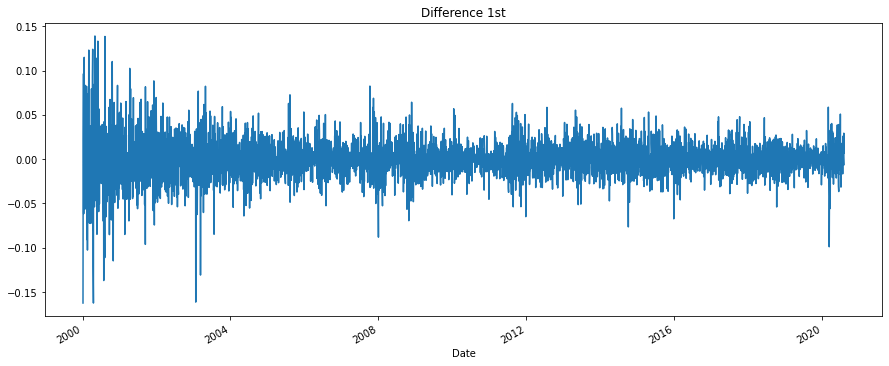

In [20]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA모델 훈련 및 테스트
- 모수 : p, d, q = 1, 1, 0

In [21]:
# Build and Train  Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

------------------------------
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4661
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11360.452
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 13 Aug 2020   AIC                         -22714.905
Time:                        17:37:43   BIC                         -22695.564
Sample:                             1   HQIC                        -22708.102
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0001      0.000     -0.337      0.736      -0.001       0.001
ar.L1.D.Close     0.0297      0.015      2.013      0.044       0.001       0.059
         

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 테스트 및 플로팅

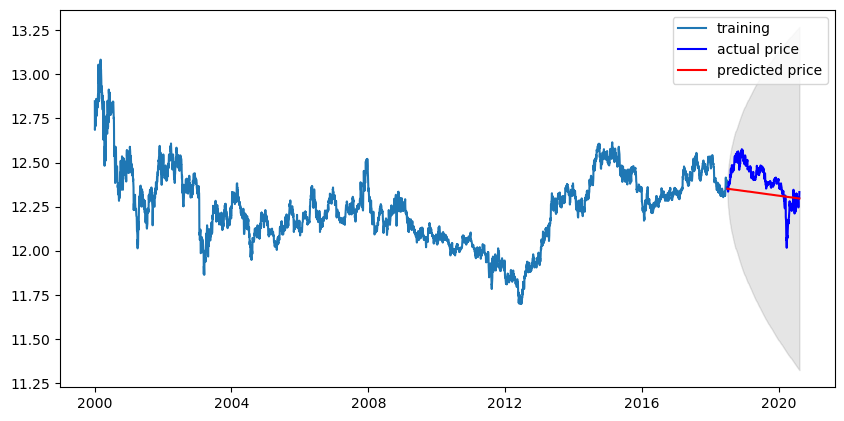

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 최종 예측 모델 정확도 측정(MAPE)

In [24]:
print_score(test_data, fc)

MSE:  772362944.1301869
MAE:  23582.98781864743
RMSE:  27791.418533968124
MAPE: 9.49%


## 3-2) Google

### 데이터 준비

In [27]:
# Time Series 생성
df = pd.read_csv('../stock_prediction/data/GOOG.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...,...
4019,2020-08-06,1471.750000,1502.390015,1466.000000,1500.099976,1500.099976,1995400
4020,2020-08-07,1500.000000,1516.844971,1481.640015,1494.489990,1494.489990,1576600
4021,2020-08-10,1487.180054,1504.074951,1473.079956,1496.099976,1496.099976,1289300
4022,2020-08-11,1492.439941,1510.000000,1478.000000,1480.319946,1480.319946,1454400


In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
Name: Close, dtype: float64

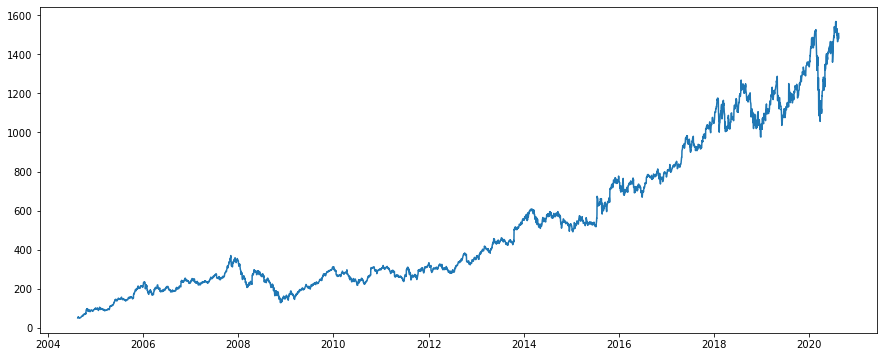

In [29]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()

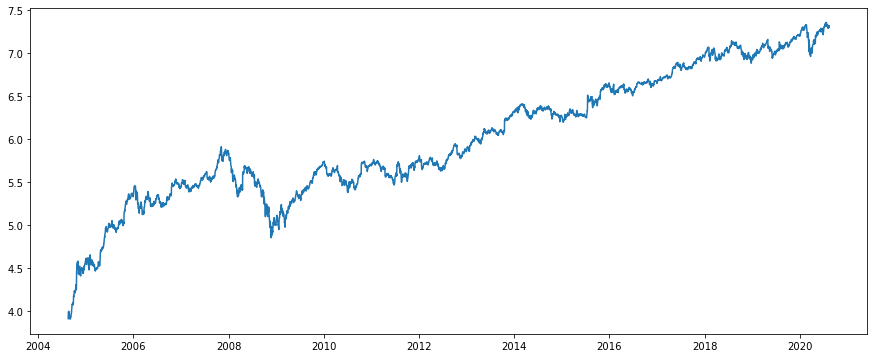

In [30]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

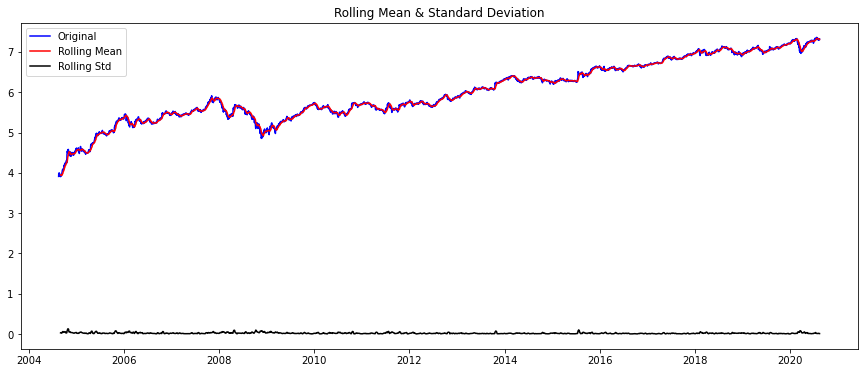

Result of Dickey-Fuller Test:
Test Statistic                   -2.296705
p-value                           0.173033
#Lags Used                       12.000000
Number of Observations Used    4011.000000
Ciritical value (1%)             -3.431981
Ciritical value (5%)             -2.862261
Ciritical value (10%)            -2.567154
dtype: float64


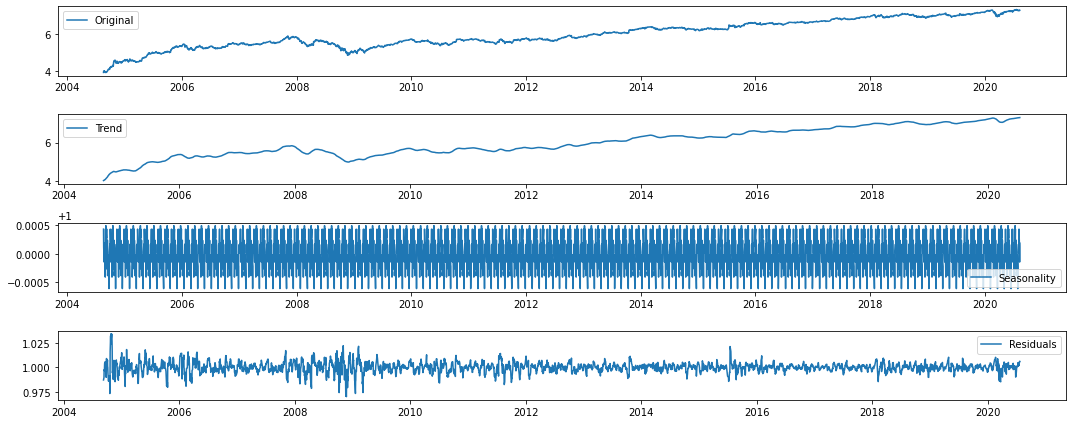

In [31]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

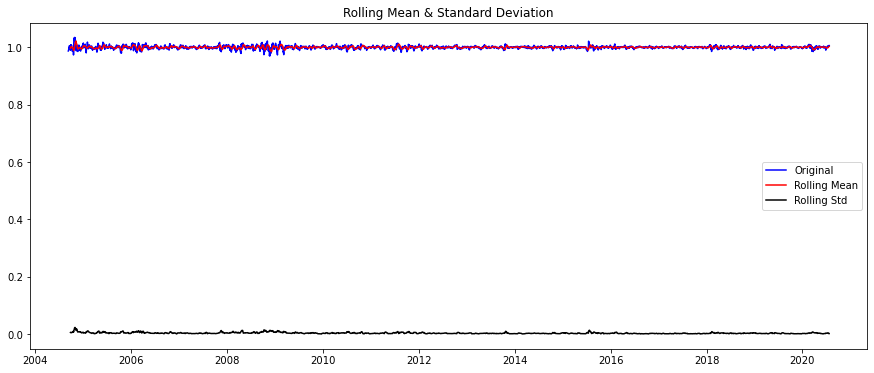

Result of Dickey-Fuller Test:
Test Statistic                -1.465120e+01
p-value                        3.498179e-27
#Lags Used                     3.000000e+01
Number of Observations Used    3.963000e+03
Ciritical value (1%)          -3.432001e+00
Ciritical value (5%)          -2.862270e+00
Ciritical value (10%)         -2.567158e+00
dtype: float64


In [32]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### 데이터 나누기

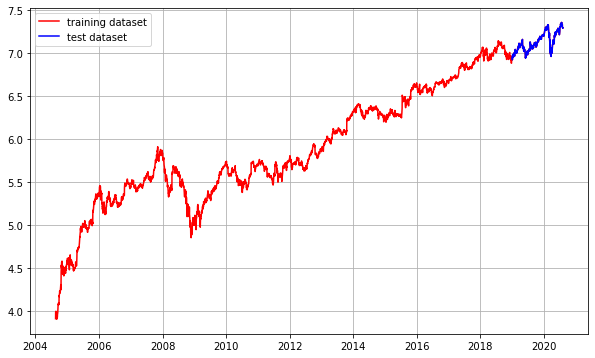

In [39]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 모수 선택

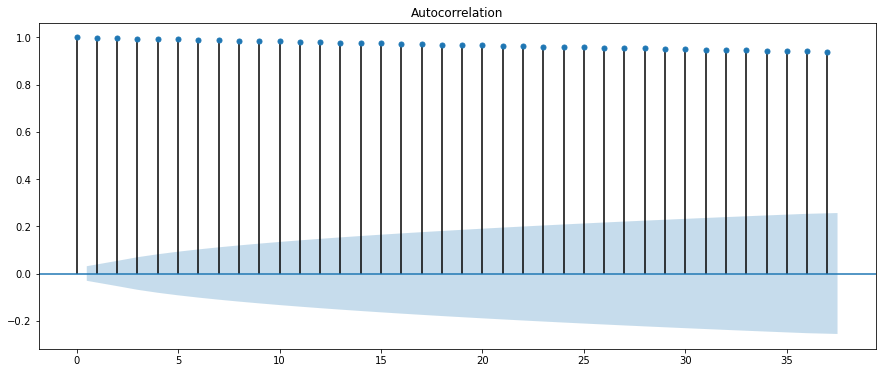

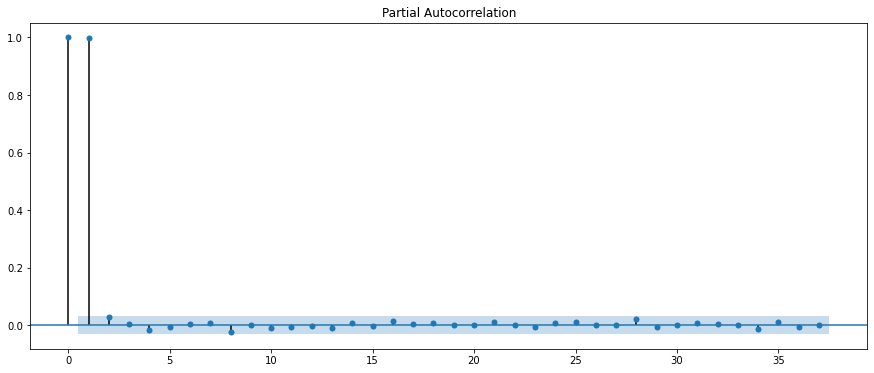

In [40]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                -1.757851e+01
p-value                        4.018321e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.006000e+03
Ciritical value (1%)          -3.431983e+00
Ciritical value (5%)          -2.862262e+00
Ciritical value (10%)         -2.567154e+00
dtype: float64


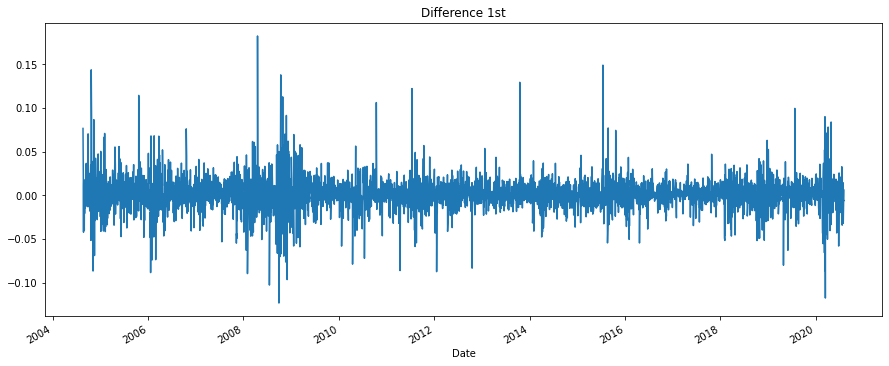

In [41]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA 모델 훈련 및 테스트

In [42]:
# Build and Train  Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)

print('-'*30)

print(fitted_m.summary())

------------------------------
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3616
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9203.957
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                         -18401.913
Time:                        17:40:34   BIC                         -18383.334
Sample:                             1   HQIC                        -18395.293
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.629      0.009       0.000       0.001
ar.L1.D.Close     0.0102      0.017      0.614      0.539      -0.022       0.043
         

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


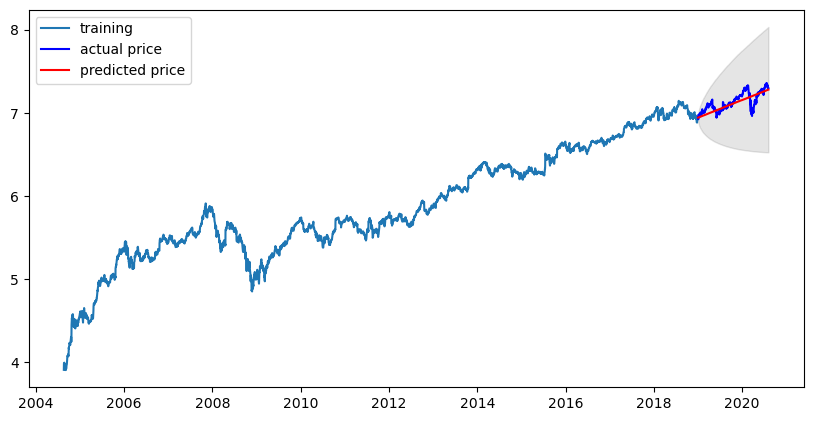

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [44]:
print_score(test_data, fc)


MSE:  8250.755951332665
MAE:  69.40073733499437
RMSE:  90.83367190272925
MAPE: 5.49%


## 3-3) AT & T

### 데이터 준비

In [88]:
# Time Series 생성
df = pd.read_csv('../stock_prediction/data/T.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-14,42.062500,42.625000,41.562500,41.875000,15.386958,3774700
1,2000-08-15,42.375000,42.687500,42.000000,42.000000,15.432896,3258100
2,2000-08-16,42.500000,42.625000,41.000000,41.312500,15.180269,4172500
3,2000-08-17,40.750000,40.875000,38.750000,39.500000,14.514272,12535100
4,2000-08-18,39.562500,39.937500,38.437500,39.312500,14.445374,8491300
...,...,...,...,...,...,...,...
5026,2020-08-06,29.709999,30.090000,29.680000,29.840000,29.840000,21908700
5027,2020-08-07,29.740000,30.059999,29.580000,30.020000,30.020000,30398500
5028,2020-08-10,30.049999,30.200001,29.990000,30.200001,30.200001,35514400
5029,2020-08-11,30.410000,30.770000,30.100000,30.200001,30.200001,30986900


In [89]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)
ts = df['Close']
ts.head()

Date
2000-08-14    41.8750
2000-08-15    42.0000
2000-08-16    41.3125
2000-08-17    39.5000
2000-08-18    39.3125
Name: Close, dtype: float64

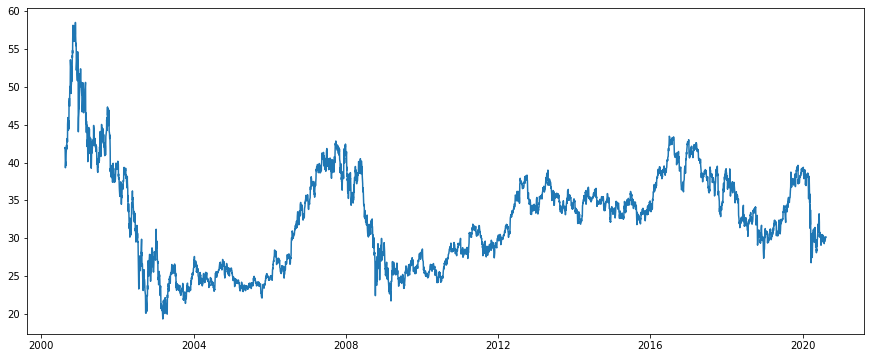

In [90]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)
plt.show()

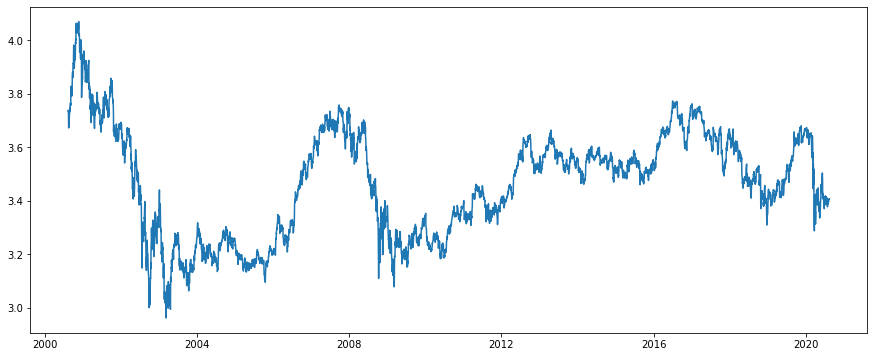

In [91]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

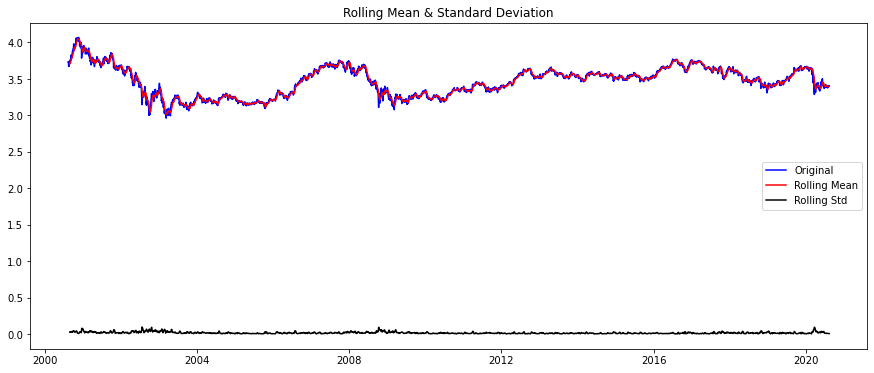

Result of Dickey-Fuller Test:
Test Statistic                   -2.595134
p-value                           0.094007
#Lags Used                        6.000000
Number of Observations Used    5024.000000
Ciritical value (1%)             -3.431652
Ciritical value (5%)             -2.862115
Ciritical value (10%)            -2.567076
dtype: float64


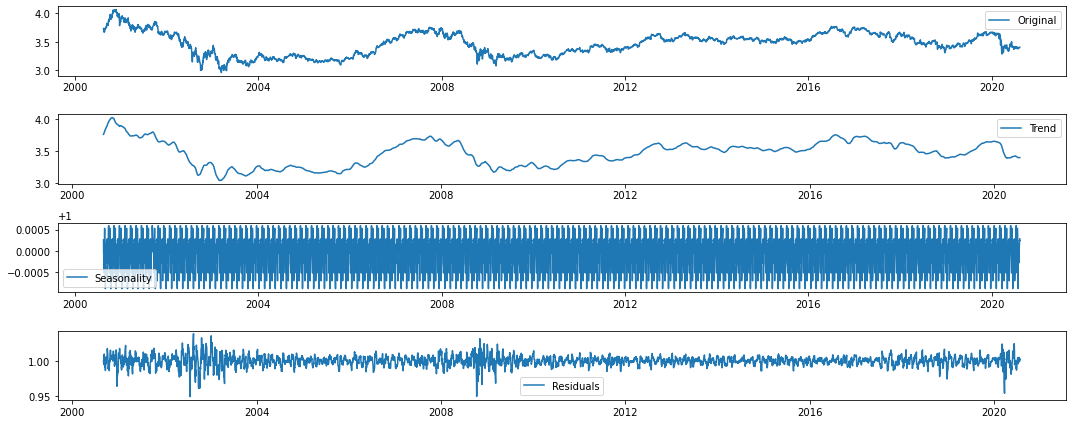

In [92]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

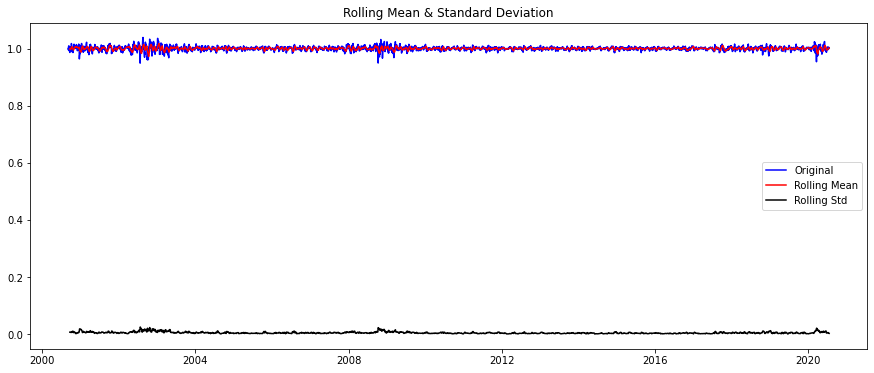

Result of Dickey-Fuller Test:
Test Statistic                -1.756053e+01
p-value                        4.098742e-30
#Lags Used                     3.200000e+01
Number of Observations Used    4.968000e+03
Ciritical value (1%)          -3.431667e+00
Ciritical value (5%)          -2.862122e+00
Ciritical value (10%)         -2.567080e+00
dtype: float64


In [93]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### 데이터 나누기

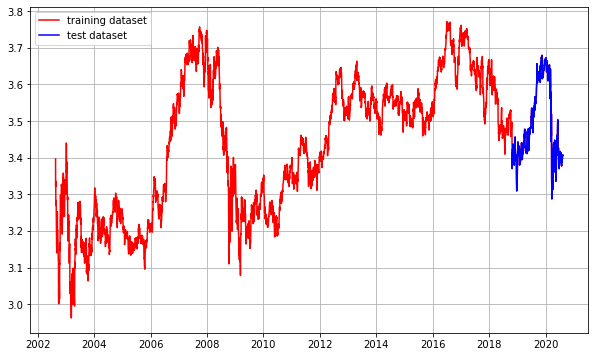

In [94]:
ts_log = ts_log[int(len(ts_log)*0.1):]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 모수 선택

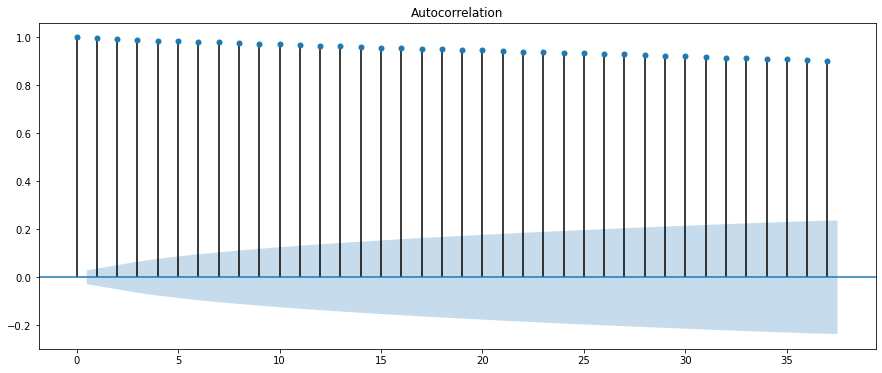

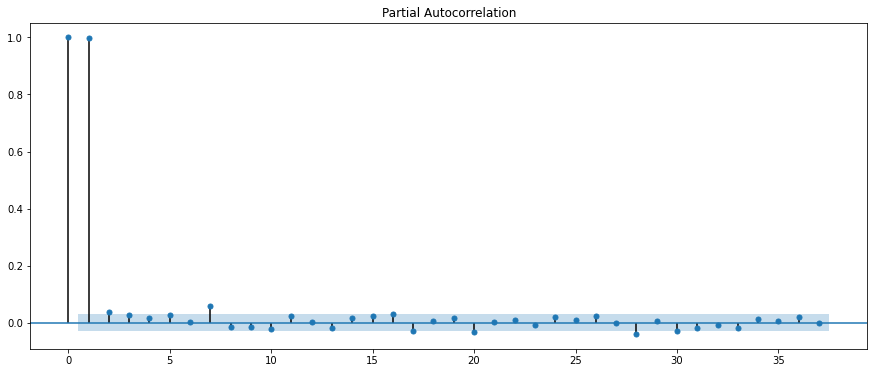

In [95]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Result of Dickey-Fuller Test:
Test Statistic                  -30.409377
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4521.000000
Ciritical value (1%)             -3.431797
Ciritical value (5%)             -2.862180
Ciritical value (10%)            -2.567110
dtype: float64


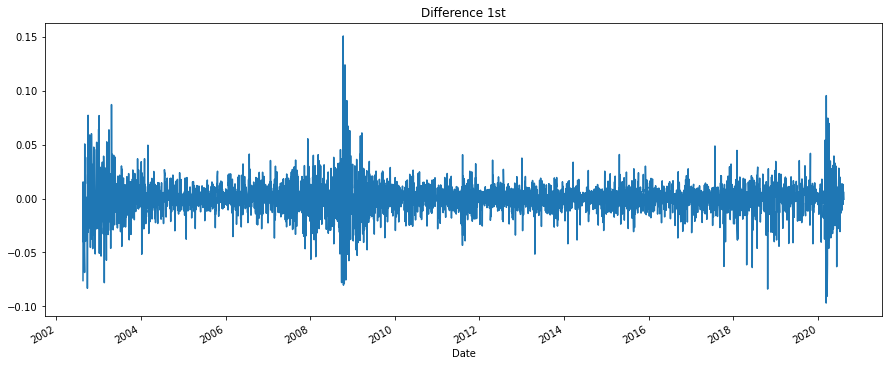

In [96]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA 모델 훈련 및 테스트

In [97]:
# Build and Train  Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)

print('-'*30)

print(fitted_m.summary())

------------------------------
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4074
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11466.085
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 13 Aug 2020   AIC                         -22926.169
Time:                        17:46:00   BIC                         -22907.232
Sample:                             1   HQIC                        -22919.463
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.489e-05      0.000      0.111      0.911      -0.000       0.000
ar.L1.D.Close    -0.0178      0.016     -1.131      0.258      -0.049       0.013
         

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


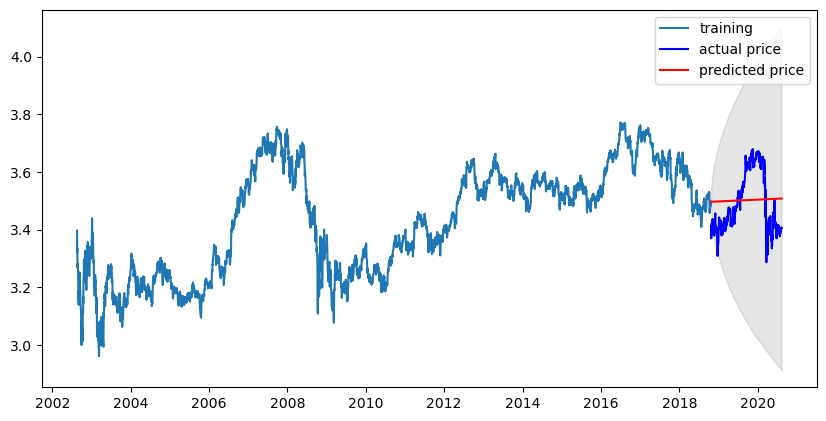

In [98]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [99]:
print_score(test_data, fc)

MSE:  11.898705661911608
MAE:  3.085005141966663
RMSE:  3.4494500520969438
MAPE: 9.27%


# 4. 정리

- 시계열이란?
    - 시간 순서대로 발생한 데이터의 수열 ```날짜 - 가격```
    - 인덱스(index) : 날짜
    <br>  
- 안정성
    - 안정적(Stationary)한 데이터에 대해서만 미래 예측이 가능하다 
    - 시계열 데이터를 활용해서 미래를 에측하기 위해서는 다음의 두가지 전제가 필요하다
        1. 과거의 데이터에 일정한 패턴이 발견된다.
        2. 과거의 패턴은 미래에도 동일하게 반복될 것이다.
    - 외부적인 요인을 추가로 고려할 수 있는 보조데이터의 활용이 정확한 예측에 도움이 된다.
        - <font color='red'>**주식**</font>
    - 시계열 데이터 분석의 전제는 외부적인 요인에 의해 <font color='red'>**훼손**</font>될 여지가 있다.
    
---  

## 3개의 기업에 대한 시계열 데이터를 활용해서 주식가격 예측하기

3가지의 기업에 대해서 주식 가격을 예측해보았다.
1. SK
    - 처음에 기존에 처리하던 방식대로 했을 경우 MAPE는 ```10.49%```로 기준에 미달 되는 점수였다.
        ![image](https://user-images.githubusercontent.com/48716219/90117614-22fa1580-dd92-11ea-97cc-641a49311820.png)
    - 최근까지 떨어졌다가 오르기 시작한 주식에 대해서 예측을 제대로 못하는 것이 아닌가  해서 오르고 있는 부분을 조금 잘라보았다. (기존 주식 데이터의 0.999%)
        ![image](https://user-images.githubusercontent.com/48716219/90117587-1b3a7100-dd92-11ea-85f4-99aa0a6861a2.png)
    - MAPE 수치는 ```9.49%```로 낮아졌다.
2. Google
    - 구글의 대한 주식그래프는 다음과 같았다.
        ![image](https://user-images.githubusercontent.com/48716219/90117934-86844300-dd92-11ea-8f0d-241fc3c4c0e4.png)
    - 전체적으로 상승을 하고 있고 크게 떨어지는 부분도 없었다.
    - 예측과정에서 SK처럼 따로 수정하지 않아도 ```5.49%```의 좋은 점수가 나왔다.
3. AT & T  
    - 구글에 비해서 꾸준히 오르지는 않지만 상승과 하강폭이 sk에 비해서 단조롭다.
        ![image](https://user-images.githubusercontent.com/48716219/90118149-c8ad8480-dd92-11ea-90c8-af4a946e5139.png)
    - MAPE 수치는 ```9.27%```이지만 다음과 같이 예측 범위가 매우 크게 나온다.
        ![image](https://user-images.githubusercontent.com/48716219/90118295-014d5e00-dd93-11ea-9baa-5a0d8038ecd8.png)
  
---

## 결론
- 주식을 시계열 데이터로 예측을 하기에는 외부적인 요소에 의해 영향을 많이 받는 것 같다.
    - 코로나(2020), 서브프라임 모기지 사태(2008)
- SK를 제외한 국내에 Kakao, 현대 자동차와 같은 경우를 보면 최근에 급격하게 주식이 오른 것을 확인 할 수 있었다.
    - 이러한 급격한 변화로 인해 시계열 데이터에 대한 안정성이 훼손될 수도 있다는 점을 확인했다.

- 더 나아가 생각해본다면 단순히 시간에 대한 정보 뿐만이 아니라 외부적인 요소가 반드시 필요한 분야가 주식을 예측하는 것 같다. 기존에 크고 작은 사건들과 그 사건들로 인해 영향을 받는 분야, 그 분야의 주식이 얼만큼 떨어졌는지에 대한 정보를 학습한다면 더 나은 결과를 볼 수 있지 않을까 생각해보았다.